# Next Steps

1. Get general code working in 1D

2. Write 1D code in matlab

3. Extend code to 2D in python

4. Extend to 2D in matlab

5. Incorporate mesh generation

6. Incorpoarte higher order shape functions

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root, fsolve
import scipy.linalg as la
from time import time
from tqdm import tqdm

import matplotlib.animation as animation

In [34]:
%matplotlib notebook

Traceback (most recent call last):
  File "/Users/bryn/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 387, in process
    proxy(*args, **kwargs)
  File "/Users/bryn/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 227, in __call__
    return mtd(*args, **kwargs)
  File "/Users/bryn/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_nbagg.py", line 241, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/Users/bryn/anaconda3/lib/python3.7/site-packages/matplotlib/_pylab_helpers.py", line 58, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list
Traceback (most recent call last):
  File "/Users/bryn/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 387, in process
    proxy(*args, **kwargs)
  File "/Users/bryn/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 227, in __call__
    return mtd(*args, **kwa

Consider the PDE

$$ f^0(U)_t + f^1(U)_x - (B(U)U_x)_x =0$$

over the domain $\Omega$.

We wish to approximate the solution to this PDE using finite difference in time and finite element in space.

First we substitute in the finite difference approximation of the time derivative, letting $U^n$ correspond to the solution $U$ at time $t= t_n$.

$$ \frac{1}{\Delta t}\left(f^0(U^{n})-f^0(U^{n-1})\right) + f^1(U^n)_x - (B(U^n)U_x^n)_x =0$$

Now we derive the weak form of this system. Let $V = \{v \in C^1(\Omega) : v|_{\partial \Omega} = 0\}$. Then for all $v\in V$ we have:

$$ \frac{1}{\Delta t}\int\left(f^0(U^{n})-f^0(U^{n-1})\right)v + \int f^1(U^n)_x v - \int (B(U^n)U_x^n)_xv =0$$

Now we can apply integration by parts to simiplify out problem to:

$$ \frac{1}{\Delta t}\int f^0(U^{n})v -\frac{1}{\Delta t}\int f^0(U^{n-1})v - \int f^1(U^n) v_x + \int B(U^n)U_x^nv_x  = 0$$

Now we take a finite subspace of our solution space with basis functions $\{\phi_i\}_{i=0}^N$ and we let $v = \sum c_j\phi_j$ and $U^n = \sum A_i^n \phi_i$. 

Plugging these approximations back into our weak form we get. 

$$ \frac{1}{\Delta t}\int f^0(\sum A_i^n\phi_i)(\sum c_j\phi_j) -\frac{1}{\Delta t}\int f^0(\sum A_i^{n-1}\phi_i)(\sum c_j\phi_j) - \int f^1(\sum A_i^n\phi_i) (\sum c_j\phi_j') + \int B(\sum A_i^n\phi_i)(\sum A_i^n\phi_i')(\sum c_j\phi_j') = 0$$

Which is equivalent to:

$$ \sum c_j \left( \frac{1}{\Delta t}\int f^0(\sum A_i^n\phi_i)\phi_j -\frac{1}{\Delta t}\int f^0(\sum A_i^{n-1}\phi_i)\phi_j - \int f^1(\sum A_i^n\phi_i) \phi_j' + \int B(\sum A_i^n\phi_i)(\sum A_i^n\phi_i')\phi_j'  \right) = 0$$

Now since this must be true for any set $\{c_j\} \subset \mathbb{R}$ it follows that for each j

$$  \frac{1}{\Delta t}\int f^0(\sum A_i^n\phi_i)\phi_j -\frac{1}{\Delta t}\int f^0(\sum A_i^{n-1}\phi_i)\phi_j - \int f^1(\sum A_i^n\phi_i) \phi_j' + \int B(\sum A_i^n\phi_i)(\sum A_i^n\phi_i')\phi_j'  = 0$$

Now we will define 


$$
\phi_j(x) = \left\{
        \begin{array}{ll}
            (x - x_{j-1})/h & \quad x \in [x_{j-1},x_j] \\
            (x_{j+1} - x)/h & \quad x \in [x_{j},x_{j+1}] \\
            0 & \quad otherwise
        \end{array}
    \right.
$$

Thus $\phi_j$ is only nonzero on the domain $[x_{j-1},x_{j+1}]$ which corresponds to the elements $e_j$ and $e_{j+1}$. Due to the linearity of the integral we can write our equation equivalently as:

$$ \sum_{k=0}^N \left( \frac{1}{\Delta t}\int_{e_k} f^0(\sum A_i^n\phi_i)\phi_j -\frac{1}{\Delta t}\int_{e_k} f^0(\sum A_i^{n-1}\phi_i)\phi_j - \int_{e_k} f^1(\sum A_i^n\phi_i) \phi_j' + \int_{e_k} B(\sum A_i^n\phi_i)(\sum A_i^n\phi_i')\phi_j'  \right)= 0$$

And then because $\int_{e_k} \phi_j = 0 \quad \forall k \neq j,{j+1}$ this simplifies to
$$ \sum_{k=j}^{j+1} \left( \frac{1}{\Delta t}\int_{e_k} f^0(\sum A_i^n\phi_i)\phi_j -\frac{1}{\Delta t}\int_{e_k} f^0(\sum A_i^{n-1}\phi_i)\phi_j - \int_{e_k} f^1(\sum A_i^n\phi_i) \phi_j' + \int_{e_k} B(\sum A_i^n\phi_i)(\sum A_i^n\phi_i')\phi_j'  \right)= 0$$

Since we are only looking at the local intervals over each element $e_k$ our approximation for $U$ will now be $U = A_{k-1}\phi_{k-1}+A_k\phi_k$

Now assuming that $f^0$ and $f^1$ are polynomials with low enough order, we can exactly evaluate the intervals using gauss quadrature with the appropriate number of points. Let $q \in \mathbb{Z}$ be the number of gauss quadrature points. Then our equation to solve becomes. 

(fix this next line)

$$ \sum_{k=j}^{j+1} \left( \frac{1}{\Delta t}\int_{e_k} f^0(\sum A_i^n\phi_i)\phi_j -\frac{1}{\Delta t}\int_{e_k} f^0(\sum A_i^{n-1}\phi_i)\phi_j - \int_{e_k} f^1(\sum A_i^n\phi_i) \phi_j' + \int_{e_k} B(\sum A_i^n\phi_i)(\sum A_i^n\phi_i')\phi_j'  \right)= 0$$

# Element Class

In [35]:
class element():
    def __init__( self, id, n1, n2 ):
        self.id = id           # global element id
        self.ind1 = id
        self.ind2 = id+1
        self.n1 = n1           # loc of left node
        self.n2 = n2           # loc of right node
        self.m = 1/(n2-n1)     # shape func slope
        
    def shape_vals(self, x):
        # returns the value of 
        # each shape function at x
        
        v1 = self.m * (self.n1-x) + 1
        v2 = self.m * (x-self.n2) + 1
        return v1, v2
    
    def shape_d_vals(self,x):
        # returns the derivative of 
        # each shape function at x
        
        v1 = -self.m * np.ones_like(x)
        v2 = self.m * np.ones_like(x)
        return v1, v2
    
    def quad_vals(self):
        # returns the value and the
        # derivative of each shape
        # function at the 3 quad pts
        
        # quad points
        xi =[ -np.sqrt(3/5), 0, np.sqrt(3/5) ]
        
        # maps local quad points to global points
        to_glob = lambda x: (x+1)/(self.m*2)+self.n1
        globs = np.array([to_glob(i) for i in xi])
        
        # get shape func vals
        vals = self.shape_vals(globs)
        
        # get shape func derivs
        derivs = self.shape_d_vals(globs)
        
        # return vals, derivs, and global points
        # note row1 of vals is phi_1 at xis
        return np.array(vals), np.array(derivs), globs

# Mesh Class

In [36]:
class mesh():
    """
    Creates a mesh object and initializes nodes
    and elements that make up the mesh
    
    Attributes:
        geom     (geom): the geometry of the mesh
        dim       (int): dimension of the mesh
        n         (int): number of elements
        nodes    (dict): dictionary mapping the dimension to an 
                         array of the nodes in that dimension
        elements (list): list of elements in the mesh
        
    Functions:
        _defineNodes: defines and stores nodes
        _initElements: create and store elements
    """
    def __init__(self,n):
        """
        Initialized mesh by defining nodes and creating
        element objects
        
        Arguments:
            geom (geom): the geometry of the mesh
            n     (int): number of elements
        """
        self.n = n
        self._defineNodes()
        self._initElements()
        
    def _defineNodes(self):
        """ Define and store nodes """
        self.nodes = np.linspace(0,1,self.n+1) 
        return
        
    def _initElements(self):
        """ Create and store elements """
        self.elements = []
        
        # iterate over each dimension
        for i in range(self.n):
            n1 = self.nodes[i]
            n2 = self.nodes[i+1]
            self.elements.append(element(i,n1,n2))
        return

# Solve Class

In [67]:
class solve():
    def __init__(self,init,f0,f1,b,nt,nx,left,right):
        self.init = init
        self.f0 = f0
        self.f1 = f1
        self.b = b
        self.nt = nt
        self.nx = nx
        self.dt = 1./nt
        self.left = left
        self.right=right
        
        # initial data
        self._setup()
        
        # solve
        self._solve()
        
    def _setup(self):
        self.dom = np.linspace(0,1,self.nx+1)
        U0 = self.init(self.dom)
        self.numeq = int(len(U0.flatten())/(self.nx+1))
        
        self.mesh = mesh(nx)
        self.elements = self.mesh.elements
        
        self.U = np.zeros((self.nt+1,self.numeq*(self.nx+1)))
        self.U[0] = U0
        
    def _solve(self):
        num_eqs, nx, dt = self.numeq, self.nx, self.dt
        
        w = [5/9, 8/9, 5/9]

        # function that we want to find the root of
        def func(D, D_):
            res = np.zeros((num_eqs,nx+1))
            D = D.reshape((num_eqs,nx+1))
            D_ = D_.reshape((num_eqs,nx+1))
            
            for e in self.elements:
                # get gauss quad vals on the element
                vals, derivs, globs = e.quad_vals()

                for j in range(2):
                    approx = 0
                    for k in range(3):
                        # evaluate shape func at xi
                        v = vals[j][k]
                        dv = derivs[j][k]

                        # evaluate U approx at xi
                        U = D[:,e.ind1]*vals[0][k] + D[:,e.ind2]*vals[1][k]
                        U_ = D_[:,e.ind1]*vals[0][k] + D_[:,e.ind2]*vals[1][k]
                        dU = D[:,e.ind1]*derivs[0][k] + D[:,e.ind2]*derivs[1][k]
                        
                        # compute the integral
                        val = f0(U)*v/dt - f0(U_)*v/dt - f1(U)*dv + (b(U)@dU)*dv
                        approx += val*w[k]

                    # add to the appropriate equation in the system
                    res[:,e.id+j] += approx

#             res[:,0] = D[:,0]
#             res[:,-1] = D[:,-1]
            
            # left boundary
            
            res[:,0] = D[:,0] - self.left
            
            res[0,-1] = D[0,-1] - D[0,-2]
            res[1:,-1] = self.right[1:]
            
    
#             res[:,0] *= 0
#             res[:,-1] *= 0
#             print(D[:,0],D[:,-1])
            return res.flatten()

        
        
        for i in tqdm(range(1,self.nt+1)):
            sol = root(func, self.U[i-1], self.U[i-1])
            print(sol.success)
            self.U[i] = sol.x


In [32]:
#             for i in range(num_eqs):
#                 for bcs,pos in self.bnds:
#                     if bcs[i][0]:
#                         res[i,pos] = D[i,pos] - bcs[i][1]
#                     else:
#                         res[i,pos] = res[i][3*pos+1]
                
                
#             res[:,0] = left
#             res[:,-1] = right
#             res[1,-1] = right[1]
#             res[3,-1] = right[3]
#             res[0,-1] = res[0,-2]
#             res[2,-1] = res[2,-2]
#             res[:,0] = D[:,0] - left
#             res[1,-1] = D[1,-1] - right[1]
#             res[3,-1] = D[3,-1] - right[3]
#             res[0,-1] = D[0,-1] - D[0,-2]#res[0,-2]
#             res[2,-1] = D[2,-1] - D[2,-2]#res[2,-2]
# #             res[:,-1] = D[:,-1]
    
#             res[:,0] *= 0
#             res[:,-1] *= 0
#             print(D[:,0],D[:,-1])

# solving heat equation

In [39]:
k = .05

# function for initial condition
def initial(x):
    return 6*np.sin(np.pi*x)
    sol = []
    for _ in x:
        sol.append(2*np.maximum(.2-np.abs(_-.5),0))
    return np.array(sol)

# 
def f0(u):
    return u

def f1(u):
    return np.zeros_like(u)
    try:
        n = len(u)
    except:
        n = 1
    y = np.zeros(n)
    return y

def b(u):
    try:
        n = len(u)
    except:
        n = 1
    y = np.eye(n)
    return k*y

left = [(True,0)]
right = [(True,0)]


nt = 10
nx = 10


sol = solve(initial,f0,f1,b,nt,nx,left,right)

 50%|█████     | 5/10 [00:00<00:00, 20.00it/s]

True
True
True
True
True


100%|██████████| 10/10 [00:00<00:00, 20.47it/s]

True
True
True
True
True


In [24]:
print(sol.U.round(3))

[[ 0.     3.527  5.706  5.706  3.527  0.   ]
 [ 0.     3.2    5.178  5.178  3.2    0.   ]
 [-0.     2.904  4.699  4.699  2.904 -0.   ]
 [ 0.     2.635  4.264  4.264  2.635  0.   ]
 [ 0.     2.391  3.87   3.87   2.391  0.   ]
 [ 0.     2.17   3.511  3.511  2.17   0.   ]]


In [26]:
true.round(3)


array([[0.   , 3.527, 5.706, 5.706, 3.527, 0.   ],
       [0.   , 3.195, 5.17 , 5.17 , 3.195, 0.   ],
       [0.   , 2.895, 4.684, 4.684, 2.895, 0.   ],
       [0.   , 2.623, 4.244, 4.244, 2.623, 0.   ],
       [0.   , 2.376, 3.845, 3.845, 2.376, 0.   ],
       [0.   , 2.153, 3.484, 3.484, 2.153, 0.   ]])

(11,) (11,)


<IPython.core.display.Javascript object>


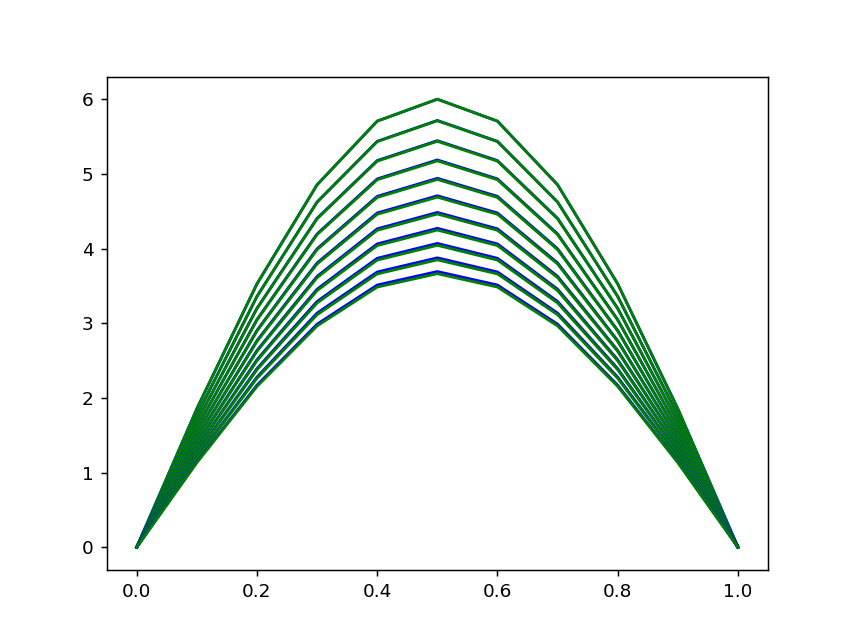

In [40]:
U = sol.U

x = np.linspace(0,1,sol.nx+1)
t = np.linspace(0,1,sol.nt+1)
print(x.shape,t.shape)
y = lambda x,t: 6*np.sin(np.pi*x)*np.exp(-k*np.pi**2*t) 

true = np.copy(U)
for i in range(sol.nt+1):
    true[i] = y(x,t[i])

# Static plot of solution
fig = plt.figure()

for i in range(sol.nt+1):
    ui = U[i,:sol.nx+1]
    plt.plot(x,ui,'b')
    plt.plot(x,true[i],'g')
    

    
plt.show()

In [22]:
if 1:
    print('hi')

hi


In [29]:
np.linalg.norm(U-true)

0.1952648942001984

In [30]:
filename = 'heat_equation_fea.mp4'
# Create our animation writer
animation.writer = animation.writers['ffmpeg']

# Define our update function that will get our solution at each time t and plot it against x
def update(i):
    curve1.set_data(x,U[i]) 
    curve2.set_data(x,true[i]) 
    return curve1, curve2

# Create our animation base figure
plt.ioff()
fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.set_ylim((-.2,6.5))
ax.set_xlim((0,1))
curve1, = plt.plot([],[], marker='o',color='r')
curve2, = plt.plot([],[], color='k')
plt.xlabel("x")
plt.title('Finite Element Solution')

ani = animation.FuncAnimation(fig,update,frames=nt+1,interval=100)
ani.save(filename)
plt.close(fig)

<video src="heat_equation_fea.mp4" controls>

# solving for 1D MHD

nu

mu https://www.engineersedge.com/physics/water__density_viscosity_specific_weight_13146.htm

cnu http://hyperphysics.phy-astr.gsu.edu/hbase/thermo/spht.html

kap https://en.wikipedia.org/wiki/Thermal_conductivity

R https://en.wikipedia.org/wiki/Gas_constant

alpha

boundary conditions

- Dirichlet for rho, u, h, T on left
- Dirichlet for u and T on right

In [292]:
print(y1)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9997, 0.9997, 0.9996, 0.9996, 0.9996, 0.9995, 0.9994, 0.9994, 0.9993, 0.9992, 0.9991, 0.999, 0.9989, 0.9987, 0.9986, 0.9984, 0.9982, 0.998, 0.9978, 0.9975, 0.9972, 0.9968, 0.9965, 0.996, 0.9956, 0.995, 0.9944, 0.9938, 0.993, 0.9922, 0.9913, 0.9903, 0.9891, 0.9879, 0.9865, 0.985, 0.9833, 0.9815, 0.9794, 0.9772, 0.9748, 0.9721, 0.9692, 0.9661, 0.9628, 0.9592, 0.9554, 0.9513, 0.947, 0.9424, 0.9376, 0.9326, 0.9275, 0.9222, 0.9167, 0.9112, 0.9056, 0.9, 0.8944, 0.8888, 0.8833, 0.878, 0.8727, 0.8676, 0.8628, 0.8581, 0.8536, 0.8494, 0.8454, 0.8416, 0.8381, 0.8348, 0.8317, 0.8289, 0.8263, 0.8238, 0.8216, 0.8196, 0.8177, 0.816, 0.8145, 0.8131, 0.8118, 0.8106, 0.8096, 0.8086, 0.8078, 0.807, 0.8063, 0.8057, 0.8051, 0.8046, 0.8041, 0.8037, 0.8

In [319]:
y1 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9998, 0.9998, 0.9998, 0.9998, 0.9997, 0.9997, 0.9997, 0.9996, 0.9996, 0.9995, 0.9995, 0.9994, 0.9994, 0.9993, 0.9992, 0.9991, 0.999, 0.9988, 0.9987, 0.9985, 0.9984, 0.9982, 0.9979, 0.9977, 0.9974, 0.9971, 0.9967, 0.9963, 0.9959, 0.9954, 0.9948, 0.9942, 0.9935, 0.9927, 0.9919, 0.9909, 0.9899, 0.9887, 0.9874, 0.9859, 0.9843, 0.9826, 0.9807, 0.9785, 0.9762, 0.9737, 0.9709, 0.968, 0.9647, 0.9613, 0.9575, 0.9536, 0.9493, 0.9449, 0.9402, 0.9353, 0.9302, 0.925, 0.9196, 0.9141, 0.9085, 0.9028, 0.8972, 0.8916, 0.886, 0.8805, 0.8752, 0.87, 0.865, 0.8602, 0.8556, 0.8512, 0.8471, 0.8432, 0.8396, 0.8362, 0.833, 0.8301, 0.8273, 0.8248, 0.8225, 0.8204, 0.8185, 0.8167, 0.8151, 0.8136, 0.8123, 0.8111, 0.81, 0.809, 0.8081, 0.8073, 0.8065, 0.8059, 0.8053, 0.8047, 0.8042, 0.8038, 0.8034, 0.8031, 0.8028, 0.8025, 0.8022, 0.802, 0.8018, 0.8016, 0.8014, 0.8013, 0.8012, 0.801, 0.8009, 0.8008, 0.8007, 0.8007, 0.8006, 0.8005, 0.8005, 0.8004, 0.8004, 0.8003, 0.8003, 0.8003, 0.8002, 0.8002, 0.8002, 0.8002, 0.8002, 0.8001, 0.8001, 0.8001, 0.8001, 0.8001, 0.8001, 0.8001, 0.8001, 0.8001, 0.8001, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]
y2 = [0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.6611, 0.6611, 0.6611, 0.6611, 0.6611, 0.6611, 0.6611, 0.6611, 0.6612, 0.6612, 0.6612, 0.6612, 0.6613, 0.6613, 0.6613, 0.6614, 0.6614, 0.6615, 0.6615, 0.6616, 0.6617, 0.6618, 0.6618, 0.662, 0.6621, 0.6622, 0.6623, 0.6625, 0.6627, 0.6629, 0.6631, 0.6634, 0.6637, 0.664, 0.6644, 0.6648, 0.6652, 0.6657, 0.6663, 0.6669, 0.6676, 0.6684, 0.6692, 0.6701, 0.6712, 0.6723, 0.6735, 0.6749, 0.6763, 0.6779, 0.6797, 0.6815, 0.6835, 0.6856, 0.6879, 0.6903, 0.6928, 0.6955, 0.6982, 0.7011, 0.704, 0.707, 0.71, 0.7131, 0.7162, 0.7193, 0.7223, 0.7253, 0.7282, 0.731, 0.7337, 0.7363, 0.7389, 0.7412, 0.7435, 0.7456, 0.7476, 0.7494, 0.7512, 0.7528, 0.7542, 0.7556, 0.7569, 0.758, 0.759, 0.76, 0.7609, 0.7617, 0.7624, 0.7631, 0.7636, 0.7642, 0.7647, 0.7651, 0.7655, 0.7659, 0.7662, 0.7665, 0.7667, 0.767, 0.7672, 0.7674, 0.7675, 0.7677, 0.7678, 0.768, 0.7681, 0.7682, 0.7683, 0.7683, 0.7684, 0.7685, 0.7685, 0.7686, 0.7686, 0.7687, 0.7687, 0.7687, 0.7688, 0.7688, 0.7688, 0.7688, 0.7689, 0.7689, 0.7689, 0.7689, 0.7689, 0.7689, 0.7689, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769]

In [61]:
y1 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9997, 0.9997, 0.9996, 0.9996, 0.9996, 0.9995, 0.9994, 0.9994, 0.9993, 0.9992, 0.9991, 0.999, 0.9989, 0.9987, 0.9986, 0.9984, 0.9982, 0.998, 0.9978, 0.9975, 0.9972, 0.9968, 0.9965, 0.996, 0.9956, 0.995, 0.9944, 0.9938, 0.993, 0.9922, 0.9913, 0.9903, 0.9891, 0.9879, 0.9865, 0.985, 0.9833, 0.9815, 0.9794, 0.9772, 0.9748, 0.9721, 0.9692, 0.9661, 0.9628, 0.9592, 0.9554, 0.9513, 0.947, 0.9424, 0.9376, 0.9326, 0.9275, 0.9222, 0.9167, 0.9112, 0.9056, 0.9, 0.8944, 0.8888, 0.8833, 0.878, 0.8727, 0.8676, 0.8628, 0.8581, 0.8536, 0.8494, 0.8454, 0.8416, 0.8381, 0.8348, 0.8317, 0.8289, 0.8263, 0.8238, 0.8216, 0.8196, 0.8177, 0.816, 0.8145, 0.8131, 0.8118, 0.8106, 0.8096, 0.8086, 0.8078, 0.807, 0.8063, 0.8057, 0.8051, 0.8046, 0.8041, 0.8037, 0.8033, 0.803, 0.8027, 0.8024, 0.8021, 0.8019, 0.8017, 0.8015, 0.8014, 0.8012, 0.8011, 0.801, 0.8009, 0.8008, 0.8007, 0.8006, 0.8006, 0.8005, 0.8005, 0.8004, 0.8004, 0.8003, 0.8003, 0.8003, 0.8002, 0.8002, 0.8002, 0.8002, 0.8002, 0.8001, 0.8001, 0.8001, 0.8001, 0.8001, 0.8001, 0.8001, 0.8001, 0.8001, 0.8001, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]

y2 = [0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.6611, 0.6611, 0.6611, 0.6611, 0.6611, 0.6611, 0.6611, 0.6611, 0.6611, 0.6612, 0.6612, 0.6612, 0.6612, 0.6613, 0.6613, 0.6614, 0.6614, 0.6615, 0.6615, 0.6616, 0.6616, 0.6617, 0.6618, 0.6619, 0.662, 0.6622, 0.6623, 0.6625, 0.6626, 0.6628, 0.6631, 0.6633, 0.6636, 0.6639, 0.6643, 0.6646, 0.6651, 0.6656, 0.6661, 0.6667, 0.6673, 0.6681, 0.6689, 0.6698, 0.6708, 0.6718, 0.673, 0.6743, 0.6757, 0.6772, 0.6789, 0.6807, 0.6826, 0.6847, 0.6869, 0.6892, 0.6917, 0.6942, 0.6969, 0.6997, 0.7026, 0.7055, 0.7086, 0.7116, 0.7147, 0.7177, 0.7207, 0.7237, 0.7267, 0.7295, 0.7323, 0.735, 0.7375, 0.7399, 0.7423, 0.7444, 0.7465, 0.7484, 0.7502, 0.7519, 0.7534, 0.7548, 0.7561, 0.7573, 0.7584, 0.7594, 0.7604, 0.7612, 0.762, 0.7627, 0.7633, 0.7639, 0.7644, 0.7648, 0.7653, 0.7656, 0.766, 0.7663, 0.7666, 0.7668, 0.767, 0.7672, 0.7674, 0.7676, 0.7677, 0.7679, 0.768, 0.7681, 0.7682, 0.7683, 0.7684, 0.7684, 0.7685, 0.7685, 0.7686, 0.7686, 0.7687, 0.7687, 0.7687, 0.7688, 0.7688, 0.7688, 0.7688, 0.7689, 0.7689, 0.7689, 0.7689, 0.7689, 0.7689, 0.7689, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769, 0.769]
print(y1[-1],y2[-1])
y1 = y1[::10]
y2 = y2[::10]

print(len(y1),len(y2),y1,y2)

0.8 0.769
21 21 [1.0, 1.0, 1.0, 0.9999, 0.9998, 0.9994, 0.998, 0.9938, 0.9815, 0.9513, 0.9, 0.8494, 0.8196, 0.807, 0.8024, 0.8008, 0.8003, 0.8001, 0.8, 0.8, 0.8] [0.661, 0.661, 0.661, 0.661, 0.6611, 0.6613, 0.662, 0.6643, 0.6708, 0.6869, 0.7147, 0.7423, 0.7584, 0.7653, 0.7677, 0.7686, 0.7689, 0.769, 0.769, 0.769, 0.769]


In [203]:
#y1 = [1.0, 1.0, 0.9998, 0.998, 0.9815, 0.9, 0.8196, 0.8024, 0.8003, 0.8, 0.8]
#y2 = [0.661, 0.661, 0.6611, 0.662, 0.6708, 0.7147, 0.7584, 0.7677, 0.7689, 0.769, 0.769]

In [204]:
#y1 = [y1[0],y1[-1]]
#y2 = [y2[0],y2[-1]]

In [62]:
Gamma = .666
mu = .1
eta = -2/3*mu
cnu = 1
kap = .1
nu = .1

u = y1
rho = [1/_ for _ in u]
T = [cnu/_ for _ in y2]
h1 = [0 for _ in y2]

start = np.array([rho,u,h1,T])

<IPython.core.display.Javascript object>


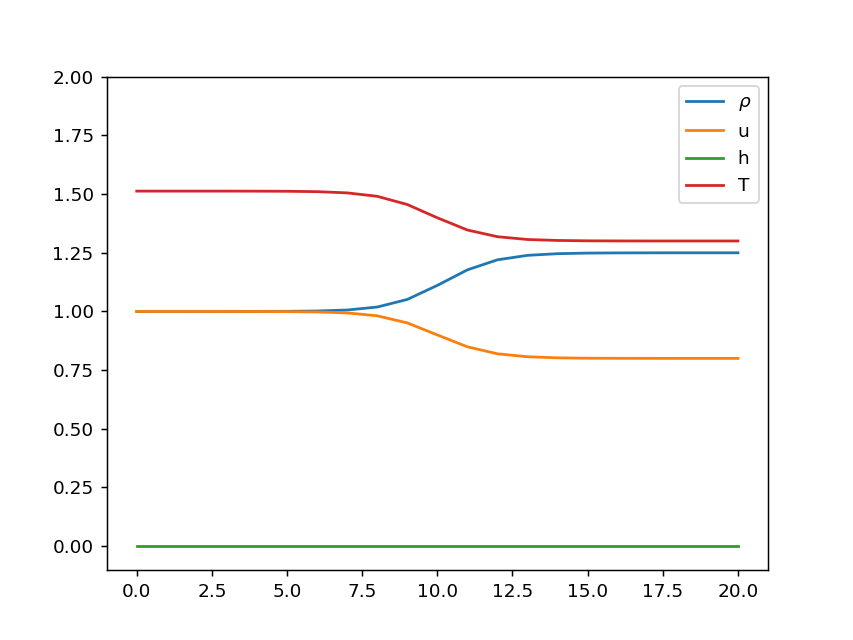

In [63]:
fig = plt.figure()
plt.plot(rho,label=r'$\rho$')
plt.plot(u,label='u')
plt.plot(h1,label='h')
plt.plot(T,label='T')
plt.ylim(-.1,2)
plt.legend()
plt.show()

In [73]:
#nu, mu, cnu, kap, R, alpha = 4.186, 0.6089, 8.314, 1

R = Gamma*cnu
alpha = 1

# function for initial condition
def initial(x):
    assert len(x) == len(y1)
    
    sol = np.zeros((4,len(y1)))
    sol[0] = rho
    sol[1] = u
    sol[2] = h1
    sol[3] = T
    return sol.flatten()
    
# 
def f0(u):
    res = np.copy(u)
    res[0] = u[0]
    res[1] = u[0]*u[1]
    res[2] = u[2]
    res[3] = u[2]**2/2+u[0]*(cnu*u[3]+u[1]**2/2)
    return res

def f1(u):
    res = np.copy(u)
    res[0] = u[0]*u[1]
    res[1] = R*u[0]*u[3]-u[2]**2/2+u[0]*u[1]**2
    res[2] = alpha*u[2]
    res[3] = (R+cnu)*u[3]+u[1]**2/2
    return res


def b(u):
    B = np.array([[0,0,0,0],
                 [0,nu+2*mu,0,0],
                 [0,0,nu,0],
                 [0,u[1]*(nu+2*mu),0,kap]])
    return B


nt = int(len(y1)**2/2)
nx = len(y1) - 1
print(nx)


left = [rho[0],u[0],h1[0],T[0]]
right = [rho[-1],u[-1],h1[-1],T[-1]]

sol = solve(initial,f0,f1,b,nt,nx,left,right)

U = sol.U.reshape((sol.nt+1,sol.numeq,sol.nx+1))
print(sol.left,sol.right)
print(U[0])


  0%|          | 0/220 [00:00<?, ?it/s]

20



  0%|          | 1/220 [00:01<04:05,  1.12s/it]

False



  1%|          | 2/220 [00:02<04:08,  1.14s/it]

False



  1%|▏         | 3/220 [00:03<04:02,  1.12s/it]

False



  2%|▏         | 4/220 [00:04<03:58,  1.10s/it]

False



  2%|▏         | 5/220 [00:05<03:53,  1.08s/it]

False



  3%|▎         | 6/220 [00:06<03:49,  1.07s/it]

False



  3%|▎         | 7/220 [00:07<03:50,  1.08s/it]

False



  4%|▎         | 8/220 [00:08<03:52,  1.10s/it]

False



  4%|▍         | 9/220 [00:09<03:52,  1.10s/it]

False



  5%|▍         | 10/220 [00:10<03:51,  1.10s/it]

False



  5%|▌         | 11/220 [00:12<04:01,  1.15s/it]

False



  5%|▌         | 12/220 [00:13<04:05,  1.18s/it]

False



  6%|▌         | 13/220 [00:14<03:56,  1.14s/it]

False



  6%|▋         | 14/220 [00:15<03:49,  1.11s/it]

False



  7%|▋         | 15/220 [00:16<03:45,  1.10s/it]

False



  7%|▋         | 16/220 [00:17<03:41,  1.08s/it]

False



  8%|▊         | 17/220 [00:18<03:36,  1.07s/it]

False



  8%|▊         | 18/220 [00:19<03:39,  1.08s/it]

False



  9%|▊         | 19/220 [00:20<03:36,  1.08s/it]

False



  9%|▉         | 20/220 [00:22<03:38,  1.09s/it]

False



 10%|▉         | 21/220 [00:23<03:39,  1.10s/it]

False



 10%|█         | 22/220 [00:24<03:40,  1.11s/it]

False



 10%|█         | 23/220 [00:25<03:46,  1.15s/it]

False



 11%|█         | 24/220 [00:26<03:39,  1.12s/it]

False



 11%|█▏        | 25/220 [00:27<03:34,  1.10s/it]

False



 12%|█▏        | 26/220 [00:28<03:34,  1.11s/it]

False



 12%|█▏        | 27/220 [00:29<03:35,  1.11s/it]

False



 13%|█▎        | 28/220 [00:31<03:32,  1.10s/it]

False



 13%|█▎        | 29/220 [00:32<03:32,  1.11s/it]

False



 14%|█▎        | 30/220 [00:33<03:39,  1.16s/it]

False



 14%|█▍        | 31/220 [00:34<03:45,  1.19s/it]

False



 15%|█▍        | 32/220 [00:35<03:41,  1.18s/it]

False



 15%|█▌        | 33/220 [00:36<03:37,  1.16s/it]

False



 15%|█▌        | 34/220 [00:38<03:32,  1.14s/it]

False



 16%|█▌        | 35/220 [00:39<03:32,  1.15s/it]

False



 16%|█▋        | 36/220 [00:40<03:29,  1.14s/it]

False



 17%|█▋        | 37/220 [00:41<03:34,  1.17s/it]

False



 17%|█▋        | 38/220 [00:42<03:32,  1.16s/it]

False



 18%|█▊        | 39/220 [00:43<03:32,  1.18s/it]

False



 18%|█▊        | 40/220 [00:45<03:37,  1.21s/it]

False



 19%|█▊        | 41/220 [00:46<03:30,  1.18s/it]

False



 19%|█▉        | 42/220 [00:47<03:27,  1.16s/it]

False



 20%|█▉        | 43/220 [00:48<03:24,  1.15s/it]

False



 20%|██        | 44/220 [00:49<03:19,  1.14s/it]

False



 20%|██        | 45/220 [00:50<03:15,  1.11s/it]

False



 21%|██        | 46/220 [00:52<03:56,  1.36s/it]

False



 21%|██▏       | 47/220 [00:53<03:46,  1.31s/it]

False



 22%|██▏       | 48/220 [00:55<03:53,  1.36s/it]

False



 22%|██▏       | 49/220 [00:56<04:01,  1.41s/it]

False



 23%|██▎       | 50/220 [00:57<03:45,  1.33s/it]

False



 23%|██▎       | 51/220 [00:59<03:33,  1.26s/it]

False



 24%|██▎       | 52/220 [01:00<03:23,  1.21s/it]

False



 24%|██▍       | 53/220 [01:01<03:15,  1.17s/it]

False



 25%|██▍       | 54/220 [01:02<03:11,  1.15s/it]

False



 25%|██▌       | 55/220 [01:03<03:07,  1.14s/it]

False



 25%|██▌       | 56/220 [01:04<03:04,  1.12s/it]

False



 26%|██▌       | 57/220 [01:05<03:12,  1.18s/it]

False



 26%|██▋       | 58/220 [01:07<03:08,  1.16s/it]

False



 27%|██▋       | 59/220 [01:08<03:03,  1.14s/it]

False



 27%|██▋       | 60/220 [01:09<02:58,  1.11s/it]

False



 28%|██▊       | 61/220 [01:10<02:55,  1.10s/it]

False



 28%|██▊       | 62/220 [01:11<02:51,  1.09s/it]

False



 29%|██▊       | 63/220 [01:12<02:52,  1.10s/it]

False



 29%|██▉       | 64/220 [01:13<03:00,  1.16s/it]

False



 30%|██▉       | 65/220 [01:14<02:56,  1.14s/it]

False



 30%|███       | 66/220 [01:15<02:52,  1.12s/it]

False



 30%|███       | 67/220 [01:16<02:49,  1.11s/it]

False



 31%|███       | 68/220 [01:18<02:46,  1.10s/it]

False



 31%|███▏      | 69/220 [01:19<02:44,  1.09s/it]

False



 32%|███▏      | 70/220 [01:20<02:42,  1.08s/it]

False



 32%|███▏      | 71/220 [01:21<02:41,  1.08s/it]

False



 33%|███▎      | 72/220 [01:22<02:43,  1.11s/it]

False



 33%|███▎      | 73/220 [01:23<02:41,  1.10s/it]

False



 34%|███▎      | 74/220 [01:24<02:40,  1.10s/it]

False



 34%|███▍      | 75/220 [01:25<02:40,  1.11s/it]

False



 35%|███▍      | 76/220 [01:26<02:38,  1.10s/it]

False



 35%|███▌      | 77/220 [01:27<02:37,  1.10s/it]

False



 35%|███▌      | 78/220 [01:28<02:32,  1.07s/it]

False



 36%|███▌      | 79/220 [01:29<02:29,  1.06s/it]

False



 36%|███▋      | 80/220 [01:30<02:27,  1.05s/it]

False



 37%|███▋      | 81/220 [01:32<02:26,  1.06s/it]

False



 37%|███▋      | 82/220 [01:33<02:24,  1.05s/it]

False



 38%|███▊      | 83/220 [01:34<02:23,  1.05s/it]

False



 38%|███▊      | 84/220 [01:35<02:20,  1.03s/it]

False



 39%|███▊      | 85/220 [01:36<02:20,  1.04s/it]

False



 39%|███▉      | 86/220 [01:37<02:19,  1.04s/it]

False



 40%|███▉      | 87/220 [01:38<02:25,  1.09s/it]

False



 40%|████      | 88/220 [01:39<02:34,  1.17s/it]

False



 40%|████      | 89/220 [01:40<02:31,  1.16s/it]

False



 41%|████      | 90/220 [01:41<02:25,  1.12s/it]

False



 41%|████▏     | 91/220 [01:42<02:19,  1.08s/it]

False



 42%|████▏     | 92/220 [01:43<02:16,  1.07s/it]

False



 42%|████▏     | 93/220 [01:44<02:13,  1.05s/it]

False



 43%|████▎     | 94/220 [01:46<02:12,  1.05s/it]

False



 43%|████▎     | 95/220 [01:47<02:10,  1.05s/it]

False



 44%|████▎     | 96/220 [01:48<02:09,  1.05s/it]

False



 44%|████▍     | 97/220 [01:49<02:08,  1.05s/it]

False



 45%|████▍     | 98/220 [01:50<02:06,  1.04s/it]

False



 45%|████▌     | 99/220 [01:51<02:04,  1.03s/it]

False



 45%|████▌     | 100/220 [01:52<02:04,  1.04s/it]

False



 46%|████▌     | 101/220 [01:53<02:02,  1.03s/it]

False



 46%|████▋     | 102/220 [01:54<02:01,  1.03s/it]

False



 47%|████▋     | 103/220 [01:55<01:59,  1.02s/it]

False



 47%|████▋     | 104/220 [01:56<01:59,  1.03s/it]

False



 48%|████▊     | 105/220 [01:57<01:57,  1.02s/it]

False



 48%|████▊     | 106/220 [01:58<01:57,  1.03s/it]

False



 49%|████▊     | 107/220 [01:59<02:02,  1.08s/it]

False



 49%|████▉     | 108/220 [02:00<02:04,  1.11s/it]

False



 50%|████▉     | 109/220 [02:02<02:08,  1.16s/it]

False



 50%|█████     | 110/220 [02:03<02:13,  1.21s/it]

False



 50%|█████     | 111/220 [02:04<02:13,  1.22s/it]

False



 51%|█████     | 112/220 [02:05<02:11,  1.22s/it]

False



 51%|█████▏    | 113/220 [02:06<02:08,  1.20s/it]

False



 52%|█████▏    | 114/220 [02:08<02:03,  1.16s/it]

False



 52%|█████▏    | 115/220 [02:09<01:59,  1.13s/it]

False



 53%|█████▎    | 116/220 [02:10<01:55,  1.11s/it]

False



 53%|█████▎    | 117/220 [02:11<01:53,  1.10s/it]

False



 54%|█████▎    | 118/220 [02:12<01:49,  1.07s/it]

False



 54%|█████▍    | 119/220 [02:13<01:47,  1.07s/it]

False



 55%|█████▍    | 120/220 [02:14<01:48,  1.08s/it]

False



 55%|█████▌    | 121/220 [02:15<01:47,  1.09s/it]

False



 55%|█████▌    | 122/220 [02:16<01:49,  1.12s/it]

False



 56%|█████▌    | 123/220 [02:17<01:51,  1.15s/it]

False



 56%|█████▋    | 124/220 [02:19<01:50,  1.16s/it]

False



 57%|█████▋    | 125/220 [02:20<01:51,  1.18s/it]

False



 57%|█████▋    | 126/220 [02:21<01:50,  1.18s/it]

False



 58%|█████▊    | 127/220 [02:22<01:45,  1.14s/it]

False



 58%|█████▊    | 128/220 [02:23<01:41,  1.10s/it]

False



 59%|█████▊    | 129/220 [02:24<01:37,  1.07s/it]

False



 59%|█████▉    | 130/220 [02:25<01:35,  1.06s/it]

False



 60%|█████▉    | 131/220 [02:26<01:33,  1.05s/it]

False



 60%|██████    | 132/220 [02:27<01:31,  1.04s/it]

False



 60%|██████    | 133/220 [02:28<01:30,  1.04s/it]

False



 61%|██████    | 134/220 [02:29<01:28,  1.03s/it]

False



 61%|██████▏   | 135/220 [02:30<01:27,  1.02s/it]

False



 62%|██████▏   | 136/220 [02:31<01:25,  1.02s/it]

False



 62%|██████▏   | 137/220 [02:32<01:24,  1.02s/it]

False



 63%|██████▎   | 138/220 [02:33<01:23,  1.02s/it]

False



 63%|██████▎   | 139/220 [02:34<01:22,  1.02s/it]

False



 64%|██████▎   | 140/220 [02:35<01:21,  1.02s/it]

False



 64%|██████▍   | 141/220 [02:36<01:20,  1.02s/it]

False



 65%|██████▍   | 142/220 [02:37<01:19,  1.02s/it]

False



 65%|██████▌   | 143/220 [02:38<01:18,  1.02s/it]

False



 65%|██████▌   | 144/220 [02:39<01:18,  1.03s/it]

False



 66%|██████▌   | 145/220 [02:41<01:21,  1.08s/it]

False



 66%|██████▋   | 146/220 [02:42<01:21,  1.10s/it]

False



 67%|██████▋   | 147/220 [02:43<01:20,  1.10s/it]

False



 67%|██████▋   | 148/220 [02:44<01:21,  1.13s/it]

False



 68%|██████▊   | 149/220 [02:45<01:21,  1.15s/it]

False



 68%|██████▊   | 150/220 [02:46<01:20,  1.15s/it]

False



 69%|██████▊   | 151/220 [02:48<01:23,  1.20s/it]

False



 69%|██████▉   | 152/220 [02:49<01:24,  1.25s/it]

False



 70%|██████▉   | 153/220 [02:50<01:21,  1.22s/it]

False



 70%|███████   | 154/220 [02:51<01:18,  1.19s/it]

False



 70%|███████   | 155/220 [02:52<01:15,  1.16s/it]

False



 71%|███████   | 156/220 [02:54<01:16,  1.19s/it]

False



 71%|███████▏  | 157/220 [02:55<01:14,  1.19s/it]

False



 72%|███████▏  | 158/220 [02:56<01:12,  1.18s/it]

False



 72%|███████▏  | 159/220 [02:57<01:10,  1.16s/it]

False



 73%|███████▎  | 160/220 [02:58<01:10,  1.17s/it]

False



 73%|███████▎  | 161/220 [03:00<01:09,  1.18s/it]

False



 74%|███████▎  | 162/220 [03:01<01:06,  1.14s/it]

False



 74%|███████▍  | 163/220 [03:02<01:03,  1.11s/it]

False



 75%|███████▍  | 164/220 [03:03<01:00,  1.08s/it]

False



 75%|███████▌  | 165/220 [03:04<00:58,  1.07s/it]

False



 75%|███████▌  | 166/220 [03:05<00:57,  1.06s/it]

False



 76%|███████▌  | 167/220 [03:06<00:55,  1.05s/it]

False



 76%|███████▋  | 168/220 [03:07<00:56,  1.09s/it]

False



 77%|███████▋  | 169/220 [03:08<00:56,  1.11s/it]

False



 77%|███████▋  | 170/220 [03:09<00:54,  1.09s/it]

False



 78%|███████▊  | 171/220 [03:10<00:53,  1.08s/it]

False



 78%|███████▊  | 172/220 [03:11<00:51,  1.06s/it]

False



 79%|███████▊  | 173/220 [03:12<00:49,  1.05s/it]

False



 79%|███████▉  | 174/220 [03:13<00:47,  1.04s/it]

False



 80%|███████▉  | 175/220 [03:14<00:46,  1.04s/it]

False



 80%|████████  | 176/220 [03:15<00:45,  1.04s/it]

False



 80%|████████  | 177/220 [03:16<00:44,  1.03s/it]

False



 81%|████████  | 178/220 [03:17<00:43,  1.03s/it]

False



 81%|████████▏ | 179/220 [03:18<00:42,  1.03s/it]

False



 82%|████████▏ | 180/220 [03:19<00:41,  1.03s/it]

False



 82%|████████▏ | 181/220 [03:20<00:40,  1.03s/it]

False



 83%|████████▎ | 182/220 [03:22<00:39,  1.04s/it]

False



 83%|████████▎ | 183/220 [03:23<00:38,  1.04s/it]

False



 84%|████████▎ | 184/220 [03:24<00:37,  1.04s/it]

False



 84%|████████▍ | 185/220 [03:25<00:36,  1.04s/it]

False



 85%|████████▍ | 186/220 [03:26<00:35,  1.04s/it]

False



 85%|████████▌ | 187/220 [03:27<00:34,  1.04s/it]

False



 85%|████████▌ | 188/220 [03:28<00:32,  1.03s/it]

False



 86%|████████▌ | 189/220 [03:29<00:31,  1.03s/it]

False



 86%|████████▋ | 190/220 [03:30<00:31,  1.03s/it]

False



 87%|████████▋ | 191/220 [03:31<00:30,  1.06s/it]

False



 87%|████████▋ | 192/220 [03:32<00:30,  1.08s/it]

False



 88%|████████▊ | 193/220 [03:33<00:29,  1.08s/it]

False



 88%|████████▊ | 194/220 [03:34<00:29,  1.12s/it]

False



 89%|████████▊ | 195/220 [03:36<00:29,  1.17s/it]

False



 89%|████████▉ | 196/220 [03:37<00:28,  1.17s/it]

False



 90%|████████▉ | 197/220 [03:38<00:27,  1.18s/it]

False



 90%|█████████ | 198/220 [03:39<00:25,  1.18s/it]

False



 90%|█████████ | 199/220 [03:40<00:24,  1.16s/it]

False



 91%|█████████ | 200/220 [03:42<00:24,  1.20s/it]

False



 91%|█████████▏| 201/220 [03:43<00:22,  1.19s/it]

False



 92%|█████████▏| 202/220 [03:44<00:21,  1.17s/it]

False



 92%|█████████▏| 203/220 [03:45<00:19,  1.13s/it]

False



 93%|█████████▎| 204/220 [03:46<00:17,  1.11s/it]

False



 93%|█████████▎| 205/220 [03:47<00:17,  1.19s/it]

False



 94%|█████████▎| 206/220 [03:49<00:16,  1.19s/it]

False



 94%|█████████▍| 207/220 [03:50<00:15,  1.20s/it]

False



 95%|█████████▍| 208/220 [03:51<00:14,  1.18s/it]

False



 95%|█████████▌| 209/220 [03:52<00:12,  1.14s/it]

False



 95%|█████████▌| 210/220 [03:53<00:11,  1.14s/it]

False



 96%|█████████▌| 211/220 [03:54<00:10,  1.13s/it]

False



 96%|█████████▋| 212/220 [03:55<00:08,  1.10s/it]

False



 97%|█████████▋| 213/220 [03:56<00:07,  1.11s/it]

False



 97%|█████████▋| 214/220 [03:57<00:06,  1.09s/it]

False



 98%|█████████▊| 215/220 [03:59<00:05,  1.14s/it]

False



 98%|█████████▊| 216/220 [04:00<00:04,  1.16s/it]

False



 99%|█████████▊| 217/220 [04:01<00:03,  1.16s/it]

False



 99%|█████████▉| 218/220 [04:02<00:02,  1.12s/it]

False



100%|█████████▉| 219/220 [04:03<00:01,  1.11s/it]

False



100%|██████████| 220/220 [04:04<00:00,  1.12s/it]


False
[1.0, 1.0, 0, 1.51285930408472] [1.25, 0.8, 0, 1.3003901170351104]
[[1.         1.         1.         1.00010001 1.00020004 1.00060036
  1.00200401 1.00623868 1.0188487  1.0511931  1.11111111 1.17730162
  1.22010737 1.23915737 1.24626122 1.24875125 1.24953143 1.24984377
  1.25       1.25       1.25      ]
 [1.         1.         1.         0.9999     0.9998     0.9994
  0.998      0.9938     0.9815     0.9513     0.9        0.8494
  0.8196     0.807      0.8024     0.8008     0.8003     0.8001
  0.8        0.8        0.8       ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [1.5128593  1.5128593  1.5128593  1.5128593  1.51263046 1.51217299
  1.51057402 1.50534397 1.4907573  1.45581598 1.39918847 1.34716422
  1.3185654  1.30667712 1.30259216 1.30106687 1.30055924 1.30039012
  1.30039012 1.30039012 1.30039012]]


<IPython.core.display.Javascript object>


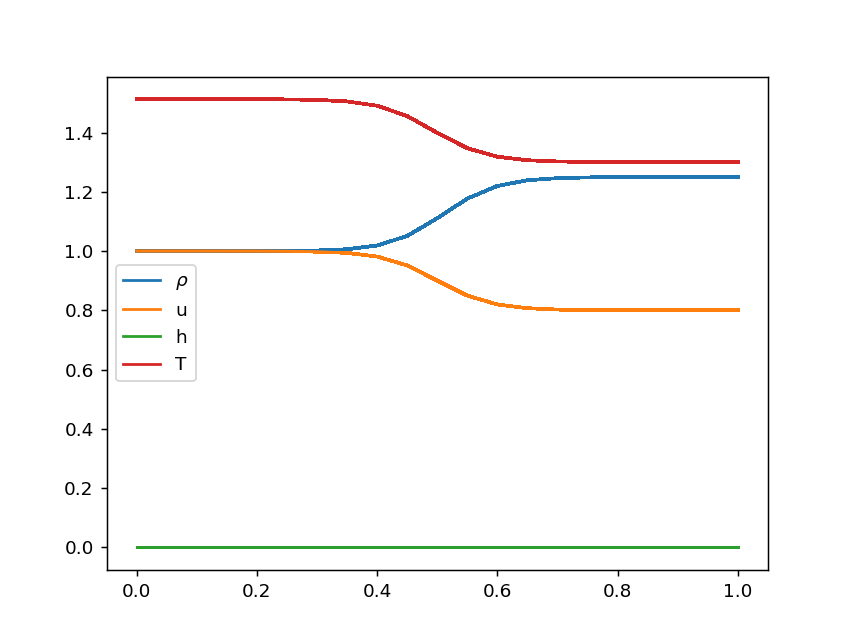

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [74]:
colors = ['C0','C1','C2','C3']
labels = [r'$\rho$','u','h','T']

# Static plot of solution
fig = plt.figure()

x = np.linspace(0,1,sol.nx+1)
for i in range(0,sol.nt+1):
    for j in range(4):
        plt.plot(x,U[i,j],color=colors[j])
    
plt.legend(labels)
# plt.ylim(.7,1.1)
plt.show()

U[0,1]==U[-1,1]

In [66]:
filename = 'mhd_fea.mp4'
# Create our animation writer
animation.writer = animation.writers['ffmpeg']

# Define our update function that will get our solution at each time t and plot it against x
def update(i):
    curve.set_data(x,U[i]) 
    return curve

# Create our animation base figure
plt.ioff()
fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.set_ylim((-.2,.5))
ax.set_xlim((0,1))
curve, = plt.plot([],[], color='r')
plt.xlabel("x")
plt.title('Finite Element Solution')

ani = animation.FuncAnimation(fig,update,frames=nt+1,interval=100)
ani.save(filename)
plt.close(fig)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

<video src="heat_equation_fea.mp4" controls>

In [ ]:
# problem parameters
f = lambda x: 2*np.maximum(.2-np.abs(x-.5),0)
nu = .05

# space and time grids
m,n = 80,350
x,dx = np.linspace(0,1,m+1,retstep=True)
t,dt = np.linspace(0,1,n+1,retstep=True)

# solution array
U2 = np.zeros((n+1,m+1))
U2[0] = f(x)

lambda_ = nu*dt/(dx**2)
# loop forward in time
for i in range(n):
    U2[i+1,1:-1] = U2[i,1:-1]+lambda_*(U2[i,2:]-2*U2[i,1:-1]+U2[i,:-2])
    
    
# Create our animation writer
animation.writer = animation.writers['ffmpeg']

# Define our update function that will get our solution at each time t and plot it against x
def update(i):
    curve.set_data(x,U2[i]) 
#     ax.set_ylabel(f"label")
#     ax.set_title(r"title")
    return curve

# Create our animation base figure
plt.ioff()
fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.set_ylim((-.2,.5))
ax.set_xlim((0,1))
curve, = plt.plot([],[], color='r')
plt.xlabel("x")
plt.title('Finite Difference Solution')

ani = animation.FuncAnimation(fig,update,frames=n+1,interval=100)
ani.save("heat_equation_fd.mp4")
plt.close(fig)

<video src="heat_equation_fd.mp4" controls>

In [ ]:
print(la.norm(U-U2), sep='\n')

In [ ]:
# function that solves the same system but assuming linearity (used KU = F)
def func2(D_):
    
    # initialize K and F
    K = np.zeros((nx+1,nx+1))
    F = np.zeros(nx+1)
    
    # Make sure D_ is correct shape
    D_ = D_.reshape((num_eqs,nx+1))
    
    for e in _elements:
        
        # get gauss quad vals on the element
        vals, derivs, globs = e.quad_vals()
        
        for j in range(2):
            fapprox = 0
            for i in range(2):
                approx = 0
                for k in range(3):
                    # evaluate shape func at xi
                    v = vals[j][k]
                    dv = derivs[j][k]

                    # evaluate U approx at xi
                    U = vals[i][k]
                    U_ = D_[:,e.id+i]*vals[i][k]
                    dU = derivs[i][k]

                    # compute the integral
                    val = f0(U)*v/dt  - f1(U)*dv + nu*(b(U)*dU)*dv
                    fval = f0(U_)*v/dt
                    approx += val*w[k]
                    fapprox += fval*w[k]
                
                # add to the appropriate equation in the system
                K[e.id+j,e.id+i] += approx
            F[e.id+j] += fapprox
            
    # incorporate boundary data
    K[-1] *= 0
    K[:,-1] *= 0
    K[-1,-1] = 1
    F[-1] = 0
    
    K[0] *= 0
    K[:,0] *= 0
    K[0,0] = 1
    F[0] = 0
    
    # solve the system
    d = la.solve(K,F)
    return d